In [1]:
import itertools
import logging
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch
from typing import List
import time
from conllu import parse
logging.basicConfig(level=logging.INFO)

DATA_PATH = "/home/wujinyi/sorbonnefile/AMAL/student_tp5/data/"

2024-10-28 15:55:26.253637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 15:55:27.666766: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 15:55:27.911287: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 15:55:29.491268: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 15:55:33.878273: W tensorflow/compiler/tf2

In [2]:
# Format de sortie décrit dans
# https://pypi.org/project/conllu/

class Vocabulary:
    """Permet de gérer un vocabulaire.

    En test, il est possible qu'un mot ne soit pas dans le
    vocabulaire : dans ce cas le token "__OOV__" est utilisé.
    Attention : il faut tenir compte de cela lors de l'apprentissage !

    Utilisation:

    - en train, utiliser v.get("blah", adding=True) pour que le mot soit ajouté
      automatiquement s'il n'est pas connu
    - en test, utiliser v["blah"] pour récupérer l'ID du mot (ou l'ID de OOV)
    """
    OOVID = 1
    PAD = 0

    def __init__(self, oov: bool):
        """ oov : autorise ou non les mots OOV """
        self.oov =  oov
        self.id2word = [ "PAD"]
        self.word2id = { "PAD" : Vocabulary.PAD}
        if oov:
            self.word2id["__OOV__"] = Vocabulary.OOVID
            self.id2word.append("__OOV__")

    def __getitem__(self, word: str):
        if self.oov:
            return self.word2id.get(word, Vocabulary.OOVID)
        return self.word2id[word]

    def get(self, word: str, adding=True):
        try:
            return self.word2id[word]
        except KeyError:
            if adding:
                wordid = len(self.id2word)
                self.word2id[word] = wordid
                self.id2word.append(word)
                return wordid
            if self.oov:
                return Vocabulary.OOVID
            raise

    def __len__(self):
        return len(self.id2word)

    def getword(self,idx: int):
        if idx < len(self):
            return self.id2word[idx]
        return None

    def getwords(self,idx: List[int]):
        return [self.getword(i) for i in idx]



class TaggingDataset():
    def __init__(self, data, words: Vocabulary, tags: Vocabulary, adding=True):
        self.sentences = []

        for s in data:
            self.sentences.append(([words.get(token["form"], adding) for token in s], [tags.get(token["upostag"], adding) for token in s]))
    def __len__(self):
        return len(self.sentences)
    def __getitem__(self, ix):
        return self.sentences[ix]


def collate_fn(batch):
    """Collate using pad_sequence"""
    return tuple(pad_sequence([torch.LongTensor(b[j]) for b in batch]) for j in range(2))

In [3]:
logging.info("Loading datasets...")
words = Vocabulary(True)
tags = Vocabulary(False)

data_file = open(DATA_PATH+"fr_gsd-ud-train.conllu")
raw_train = [parse(x)[0] for x in data_file if len(x)>1]
data_file = open(DATA_PATH+"fr_gsd-ud-dev.conllu")
raw_dev = [parse(x)[0] for x in data_file if len(x)>1]
data_file = open(DATA_PATH+"fr_gsd-ud-test.conllu")
raw_test = [parse(x)[0] for x in data_file if len(x)>1]

train_data = TaggingDataset(raw_train, words, tags, True)
dev_data = TaggingDataset(raw_dev, words, tags, True)
test_data = TaggingDataset(raw_test, words, tags, False)


logging.info("Vocabulary size: %d", len(words))


BATCH_SIZE=100

train_loader = DataLoader(train_data, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_data, collate_fn=collate_fn, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, collate_fn=collate_fn, batch_size=BATCH_SIZE)

INFO:root:Loading datasets...
INFO:root:Vocabulary size: 44939


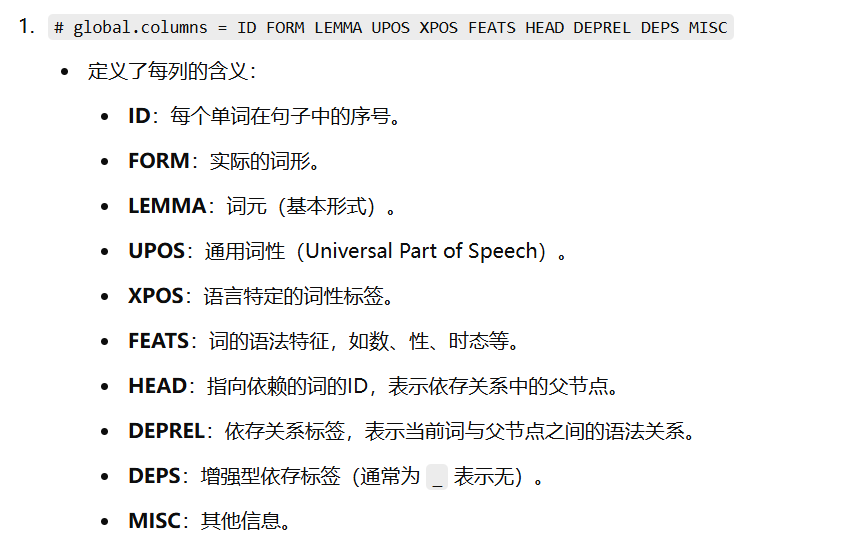

In [4]:
#  TODO:  Implémenter le modèle et la boucle d'apprentissage (en utilisant les LSTMs de pytorch)
class Seq2SeqTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim):
        super(Seq2SeqTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=Vocabulary.PAD)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
    
    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed_input = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hn, cn) = self.lstm(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        logits = self.fc(output)
        return logits


def train_model(model, train_loader, dev_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for sentences, tags in tqdm(train_loader):
            sentences, tags = sentences.to(device), tags.to(device)
            lengths = [len(s) for s in sentences]  # 获取每个句子的长度
            optimizer.zero_grad()
            logits = model(sentences, lengths)
            
            # 计算损失，忽略填充的部分
            logits = logits.view(-1, logits.shape[-1])
            tags = tags.view(-1)
            loss = criterion(logits, tags)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")
        
        # 在开发集上验证
        evaluate_model(model, dev_loader, criterion)


def evaluate_model(model, dev_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for sentences, tags in dev_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            lengths = [len(s) for s in sentences]
            logits = model(sentences, lengths)
            logits = logits.view(-1, logits.shape[-1])
            tags = tags.view(-1)
            loss = criterion(logits, tags)
            total_loss += loss.item()

    print(f"Validation Loss: {total_loss/len(dev_loader):.4f}")

In [6]:
# 模型超参数
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
TAGSET_SIZE = len(tags)
VOCAB_SIZE = len(words)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型、损失函数和优化器
model = Seq2SeqTagger(VOCAB_SIZE, TAGSET_SIZE, EMBEDDING_DIM, HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=Vocabulary.PAD)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
NUM_EPOCHS = 5
train_model(model, train_loader, dev_loader, criterion, optimizer, NUM_EPOCHS)

# 在测试集上评估
evaluate_model(model, test_loader, criterion)

100%|██████████| 3932/3932 [01:52<00:00, 34.87it/s]


Epoch 1/5, Loss: 0.6900
Validation Loss: 0.4742


100%|██████████| 3932/3932 [02:12<00:00, 29.74it/s]


Epoch 2/5, Loss: 0.3780
Validation Loss: 0.3727


100%|██████████| 3932/3932 [02:10<00:00, 30.17it/s]


Epoch 3/5, Loss: 0.2763
Validation Loss: 0.3445


100%|██████████| 3932/3932 [02:02<00:00, 32.20it/s]


Epoch 4/5, Loss: 0.2175
Validation Loss: 0.3407


100%|██████████| 3932/3932 [01:59<00:00, 33.03it/s]


Epoch 5/5, Loss: 0.1781
Validation Loss: 0.3410
Validation Loss: 0.3401


In [ ]:
def predict_tags(model, sentence: List[str], word_vocab: Vocabulary, tag_vocab: Vocabulary):
    # 将输入句子转换为词汇表中的索引
    sentence_idx = [word_vocab.get(word, adding=False) for word in sentence]
    sentence_tensor = torch.LongTensor(sentence_idx).unsqueeze(0).to(device)  # 转换为tensor并增加batch维度
    lengths = [len(sentence_idx)]

    # 模型预测
    model.eval()
    with torch.no_grad():
        logits = model(sentence_tensor, lengths)
    
    # 获取每个单词的预测标签
    predicted_tags_idx = logits.argmax(dim=-1).squeeze().cpu().numpy()
    predicted_tags = tag_vocab.getwords(predicted_tags_idx)

    # 显示输入句子和对应的标签
    for word, tag in zip(sentence, predicted_tags):
        print(f"{word} -> {tag}")

# 示例输入句子
input_sentence = ["Je", "suis", "étudiant", "à", "l'université", "Sorbonne"]
predict_tags(model, input_sentence, words, tags)